# Imports

In [463]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

from imblearn.over_sampling import RandomOverSampler

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin



# Criando o data frame

In [464]:
df_train = pd.read_csv('archive/train.csv')
df_test = pd.read_csv('archive/train.csv')

In [465]:
df_train.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel   
0           0   70172    Male     Loyal Customer   13  Personal Travel  \
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service   
0  Eco Plus              460                      3  \
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment   
0                                  4  ...                       5  \
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   
4                                  3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service   
0                 4                 3                 4                4  \
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes   
0                 5            5                          25  \
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 25 columns]

Removendo coluna de id e coluna com nome nulo

In [466]:
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_train['satisfied'] = df_train['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
df_train.drop(columns=['id', 'satisfaction'], inplace=True)

df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]
df_test['satisfied'] = df_test['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
df_test.drop(columns=['id', 'satisfaction'], inplace=True)

In [467]:
# Contando o número total de linhas no dataset
total_rows = df_train.shape[0]
total_rows

103904

In [468]:
# Contando o número de linhas com dados faltantes
missing_data_count = df_train.isnull().any(axis=1).sum()
missing_data_count

310

In [469]:
# Calculando o percentual de linhas com dados faltantes
percent_missing = (missing_data_count / total_rows) * 100
print(f"O percentual de dados faltantes {percent_missing}%")

O percentual de dados faltantes 0.29835232522328303%


In [470]:
df_train.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfied 

In [471]:
# Imprimindo o maior valor da coluna Departure Delay in Minutes
max_value = df_train['Departure Delay in Minutes'].max()
print("O maior valor da coluna 'Departure Delay in Minutes' é:", max_value)


O maior valor da coluna 'Departure Delay in Minutes' é: 1592


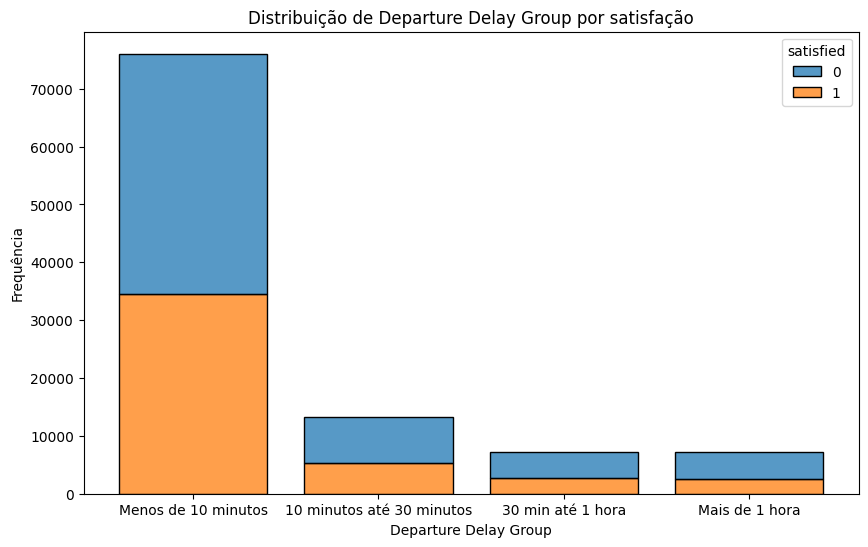

In [472]:
# Definindo os intervalos de agrupamento para Departure Delay in Minutes
bins = [-1, 10, 30, 60, float('inf')]
labels = ['Menos de 10 minutos', '10 minutos até 30 minutos', '30 min até 1 hora', 'Mais de 1 hora']
df_train['Departure Delay Group'] = pd.cut(df_train['Departure Delay in Minutes'], bins=bins, labels=labels)

# Criando um histograma para plotar a distribuição da variável agrupada com relação à variável satisfied
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Departure Delay Group', hue='satisfied', multiple='stack', shrink=0.8)
plt.title('Distribuição de Departure Delay Group por satisfação')
plt.xlabel('Departure Delay Group')
plt.ylabel('Frequência')
plt.show()

In [473]:
# Imprimindo o maior valor da coluna Departure Delay in Minutes
max_value = df_train['Arrival Delay in Minutes'].max()
print("O maior valor da coluna 'Departure Delay in Minutes' é:", max_value)


O maior valor da coluna 'Departure Delay in Minutes' é: 1584.0


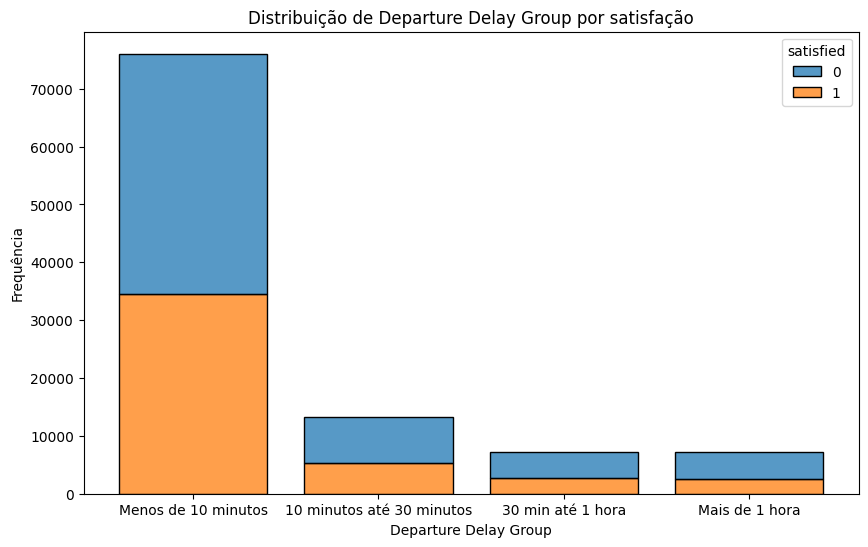

In [474]:
# Definindo os intervalos de agrupamento para Departure Delay in Minutes
bins = [-1, 10, 30, 60, float('inf')]
labels = ['Menos de 10 minutos', '10 minutos até 30 minutos', '30 min até 1 hora', 'Mais de 1 hora']
df_train['Arrival Delay Group'] = pd.cut(df_train['Arrival Delay in Minutes'], bins=bins, labels=labels)

# Criando um histograma para plotar a distribuição da variável agrupada com relação à variável satisfied
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Departure Delay Group', hue='satisfied', multiple='stack', shrink=0.8)
plt.title('Distribuição de Departure Delay Group por satisfação')
plt.xlabel('Departure Delay Group')
plt.ylabel('Frequência')
plt.show()

## Oversampling

In [475]:
class1_df = df_train[df_train['satisfied'] == 1]
class2_df = df_train[df_train['satisfied'] == 0]

In [476]:
print('Quantidade de dados na classe 1:', class1_df.shape[0])
print('Quantidade de dados na classe 2:', class2_df.shape[0])

Quantidade de dados na classe 1: 45025
Quantidade de dados na classe 2: 58879


In [477]:
class1_50_percent = class1_df.sample(frac=0.5)
remaining_class1 = class1_df.drop(class1_50_percent.index)
class1_25_percent_1 = remaining_class1.sample(frac=0.5)
class1_25_percent_2 = remaining_class1.drop(class1_25_percent_1.index)

In [478]:
print('Quantidade de dados na classe 1 50%:', class1_50_percent.shape[0])
print('Quantidade de dados na classe 1 25% 1:', class1_25_percent_1.shape[0])
print('Quantidade de dados na classe 1 25% 2:', class1_25_percent_2.shape[0])

Quantidade de dados na classe 1 50%: 22512
Quantidade de dados na classe 1 25% 1: 11256
Quantidade de dados na classe 1 25% 2: 11257


In [479]:
class2_50_percent = class2_df.sample(frac=0.5)
remaining_class2 = class2_df.drop(class2_50_percent.index)
class2_25_percent_1 = remaining_class2.sample(frac=0.5)
class2_25_percent_2 = remaining_class2.drop(class2_25_percent_1.index)

In [480]:
print('Quantidade de dados na classe 2 50%:', class2_50_percent.shape[0])
print('Quantidade de dados na classe 2 25% 1:', class2_25_percent_1.shape[0])
print('Quantidade de dados na classe 2 25% 2:', class2_25_percent_2.shape[0])

Quantidade de dados na classe 2 50%: 29440
Quantidade de dados na classe 2 25% 1: 14720
Quantidade de dados na classe 2 25% 2: 14719


In [481]:
size_difference = (len(class2_50_percent) + len(class2_25_percent_1)) - (len(class1_50_percent) + len(class1_25_percent_1))
size_difference

10392

In [482]:
to_be_oversampled = pd.concat([class2_50_percent, class2_25_percent_1, class1_50_percent, class1_25_percent_1])

In [483]:
oversampler = RandomOverSampler(random_state=42)

In [484]:
X_resampled, y_resampled = oversampler.fit_resample(to_be_oversampled.drop('satisfied', axis=1), to_be_oversampled['satisfied'])

In [485]:
df_resampled = pd.DataFrame(X_resampled, columns=df_train.drop('satisfied', axis=1).columns)
merged_df = df_resampled.join(y_resampled, how='inner')
merged_df

Gender      Customer Type  Age   Type of Travel     Class   
0        Male     Loyal Customer   68  Personal Travel       Eco  \
1        Male     Loyal Customer   51  Personal Travel       Eco   
2      Female     Loyal Customer   17  Personal Travel       Eco   
3      Female  disloyal Customer   23  Business travel       Eco   
4      Female     Loyal Customer   69  Personal Travel  Eco Plus   
...       ...                ...  ...              ...       ...   
88315  Female     Loyal Customer   50  Business travel  Business   
88316    Male     Loyal Customer   51  Business travel  Business   
88317    Male     Loyal Customer   44  Business travel       Eco   
88318    Male     Loyal Customer   56  Business travel  Business   
88319  Female     Loyal Customer   44  Business travel  Business   

       Flight Distance  Inflight wifi service   
0                  190                      3  \
1                  961                      1   
2                  894                      4   
3                  872                      2   
4                  429                      3   
...                ...                    ...   
88315             2938                      1   
88316             2861                      4   
88317              399                      5   
88318             2036                      5   
88319              583                      5   

       Departure/Arrival time convenient  Ease of Online booking   
0                                      3                       0  \
1                                      5                       1   
2                                      4                       4   
3                                      2                       2   
4                                      3                       2   
...                                  ...                     ...   
88315                                  1                       1   
88316                                  4                       4   
88317                                  4                       4   
88318                                  5                       5   
88319                                  5                       2   

       Gate location  ...  Leg room service  Baggage handling   
0                  4  ...                 3                 4  \
1                  5  ...                 3                 4   
2                  4  ...                 5                 4   
3                  4  ...                 2                 3   
4                  3  ...                 2                 5   
...              ...  ...               ...               ...   
88315              1  ...                 4                 5   
88316              4  ...                 4                 4   
88317              4  ...                 3                 2   
88318              5  ...                 5                 5   
88319              5  ...                 4                 4   

       Checkin service  Inflight service  Cleanliness   
0                    2                 3            1  \
1                    5                 4            5   
2                    3                 5            3   
3                    1                 3            3   
4                    3                 5            2   
...                ...               ...          ...   
88315                4                 5            4   
88316                3                 4            5   
88317                1                 4            5   
88318                3                 5            3   
88319                3                 4            5   

       Departure Delay in Minutes  Arrival Delay in Minutes   
0                              20                      30.0  \
1                               0                       0.0   
2                               0                       0.0   
3                              89                     105.0   
4  

In [486]:
class1_50_percent = class1_df.sample(frac=50/75)
class1_25_percent_1 = class1_df.drop(class1_50_percent.index)

In [487]:
class2_50_percent = class2_df.sample(frac=50/75)
class2_25_percent_1 = class2_df.drop(class2_50_percent.index)

## Tratamento

In [488]:
# Definir a função para categorizar os atrasos
def categorize_delay(minutes):
    if minutes < 10:
        return 'Menos de 10 minutos'
    elif minutes < 30:
        return '10 minutos até 30 minutos'
    elif minutes < 60:
        return '30 min até 1 hora'
    else:
        return 'Mais de 1 hora'

# Criar um transformador personalizado para aplicar a função de categorização
class DelayCategorizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['Departure Delay Category'] = X_transformed['Departure Delay in Minutes'].apply(categorize_delay)
        X_transformed['Arrival Delay Category'] = X_transformed['Arrival Delay in Minutes'].apply(categorize_delay)
        return X_transformed[['Departure Delay Category', 'Arrival Delay Category']]
    
    def get_feature_names_out(self, input_features=None):
        return ['Departure Delay Category', 'Arrival Delay Category']
    
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_features = [feat for feat in numeric_features if feat not in ['Departure Delay in Minutes', 'Arrival Delay in Minutes']]

categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
], memory=None)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=None)

delay_categorizer = Pipeline(steps=[
    ('categorizer', DelayCategorizer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=None)

lista = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('delay_cat', delay_categorizer, lista)
    ],
    verbose_feature_names_out=False)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)], memory=None)
df_train_processado =  pd.DataFrame(pipeline.fit_transform(df_train), columns = pipeline.get_feature_names_out())
df_test_processado = pd.DataFrame(pipeline.transform(df_test), columns = pipeline.get_feature_names_out())


In [489]:
df_train_processado.head()

Age  Flight Distance  Inflight wifi service   
0  0.076923         0.086632                    0.6  \
1  0.230769         0.041195                    0.6   
2  0.243590         0.224354                    0.4   
3  0.230769         0.107229                    0.4   
4  0.692308         0.036955                    0.6   

   Departure/Arrival time convenient  Ease of Online booking  Gate location   
0                                0.8                     0.6            0.2  \
1                                0.4                     0.6            0.6   
2                                0.4                     0.4            0.4   
3                                1.0                     1.0            1.0   
4                                0.6                     0.6            0.6   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...   
0             1.0              0.6           1.0                     1.0  ...  \
1             0.2              0.6           0.2                     0.2  ...   
2             1.0              1.0           1.0                     1.0  ...   
3             0.4              0.4           0.4                     0.4  ...   
4             0.8              1.0           1.0                     0.6  ...   

   Class_Eco  Class_Eco Plus   
0        0.0             1.0  \
1        0.0             0.0   
2        0.0             0.0   
3        0.0             0.0   
4        0.0             0.0   

   Departure Delay Category_10 minutos até 30 minutos   
0                                                1.0   \
1                                                0.0    
2                                                0.0    
3                                                1.0    
4                                                0.0    

   Departure Delay Category_30 min até 1 hora   
0                                         0.0  \
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Departure Delay Category_Mais de 1 hora   
0                                      0.0  \
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   Departure Delay Category_Menos de 10 minutos   
0                                           0.0  \
1                                           1.0   
2                                           1.0   
3                                           0.0   
4                                           1.0   

   Arrival Delay Category_10 minutos até 30 minutos   
0                                               1.0  \
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   Arrival Delay Category_30 min até 1 hora   
0                                       0.0  \
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Arrival Delay Category_Mais de 1 hora   
0                                    0.0  \
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   Arrival Delay Category_Menos de 10 minutos  
0                                         0.0  
1                                         1.0  
2                                         1.0  
3                                         1.0  
4                                         1.0  

[5 rows x 34 columns]

In [490]:
df_test_processado.head()

Age  Flight Distance  Inflight wifi service   
0  0.076923         0.086632                    0.6  \
1  0.230769         0.041195                    0.6   
2  0.243590         0.224354                    0.4   
3  0.230769         0.107229                    0.4   
4  0.692308         0.036955                    0.6   

   Departure/Arrival time convenient  Ease of Online booking  Gate location   
0                                0.8                     0.6            0.2  \
1                                0.4                     0.6            0.6   
2                                0.4                     0.4            0.4   
3                                1.0                     1.0            1.0   
4                                0.6                     0.6            0.6   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...   
0             1.0              0.6           1.0                     1.0  ...  \
1             0.2              0.6           0.2                     0.2  ...   
2             1.0              1.0           1.0                     1.0  ...   
3             0.4              0.4           0.4                     0.4  ...   
4             0.8              1.0           1.0                     0.6  ...   

   Class_Eco  Class_Eco Plus   
0        0.0             1.0  \
1        0.0             0.0   
2        0.0             0.0   
3        0.0             0.0   
4        0.0             0.0   

   Departure Delay Category_10 minutos até 30 minutos   
0                                                1.0   \
1                                                0.0    
2                                                0.0    
3                                                1.0    
4                                                0.0    

   Departure Delay Category_30 min até 1 hora   
0                                         0.0  \
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Departure Delay Category_Mais de 1 hora   
0                                      0.0  \
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   Departure Delay Category_Menos de 10 minutos   
0                                           0.0  \
1                                           1.0   
2                                           1.0   
3                                           0.0   
4                                           1.0   

   Arrival Delay Category_10 minutos até 30 minutos   
0                                               1.0  \
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   Arrival Delay Category_30 min até 1 hora   
0                                       0.0  \
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Arrival Delay Category_Mais de 1 hora   
0                                    0.0  \
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   Arrival Delay Category_Menos de 10 minutos  
0                                         0.0  
1                                         1.0  
2                                         1.0  
3                                         1.0  
4                                         1.0  

[5 rows x 34 columns]

In [491]:
df_test_processado.dtypes

Age                                                   float64
Flight Distance                                       float64
Inflight wifi service                                 float64
Departure/Arrival time convenient                     float64
Ease of Online booking                                float64
Gate location                                         float64
Food and drink                                        float64
Online boarding                                       float64
Seat comfort                                          float64
Inflight entertainment                                float64
On-board service                                      float64
Leg room service                                      float64
Baggage handling                                      float64
Checkin service                                       float64
Inflight service                                      float64
Cleanliness                                           float64
satisfie

In [492]:
df_train_processado, df_val_processado = train_test_split(df_train_processado, test_size=0.25, random_state=81)

In [493]:
df_train_processado.to_csv("dataset_tratado/train_df.csv", index=False)
df_val_processado.to_csv("dataset_tratado/validation_df.csv", index=False)
df_test_processado.to_csv("dataset_tratado/test_df.csv", index=False)